In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
#tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import pickle

import warnings
warnings.filterwarnings('ignore')

In [7]:
# fun0 read the data
#http://10.79.85.55:8887/edit/data/MGP/TestPointsN2_CH4_H2O_000.xlsx
file_name = '/data/MGP/TestPointsN2_CH4_H2O_000.xlsx'
df=pd.read_excel(file_name,header=1,engine='openpyxl').dropna(how='all', axis=1)
df.drop('#',axis=1,inplace=True)

#df=pd.read_pickle('../Reorg/DataL2a_Full.pkl'); DP='Differential Pressure [kPa]'; NN_model = "mcp_x_a_SD.h5"
# df=pd.read_pickle('DataL2b_Full.pkl'); DP='Differential Pressure'; NN_model = "mcp_x_b_SD.h5"

In [22]:
#http://10.79.85.55:8887/edit/workspace/laure/17_MCP/000_Paper/DataL2a_Full.pkl
NN_model =  "/workspace/laure/17_MCP/000_Paper/mcp_x_b_SD.h5"


In [9]:
df.shape

(63116, 36)

In [8]:
#df=pd.read_pickle('/workspace/laure/17_MCP/Reorg/DataL2a_Full.pkl'); DP='Differential Pressure [kPa]'; NN_model = "mcp_x_a_SD.h5"

In [17]:
# if DP == 'Differential Pressure':
#     df.rename(columns={DP: "Differential Pressure [kPa]"},inplace=True)

In [11]:
phi_surge = 0.076 
df['surge_distance_from_eq'] = 100*(df['phi']-phi_surge)/phi_surge 

In [12]:
# func1 required columns
columns=['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power','phi',
         'Surge Distance','surge_distance_from_eq','GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]']
inputs = ['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power']
#outputs = ['GVFin','GVFout','Qin [m3/s]','Qv_out [m3/s]','phi','Surge Distance','surge_distance_from_eq']
#outputs = ['GVFin','GVFout','Qin [m3/s]','Qv_out [m3/s]']
outputs = ['surge_distance_from_eq']
data=df[columns]
X=data[inputs]
y=data[outputs]

In [40]:
# MAE is 0.57  for batch size 32 and epochs 250 
# columns=['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power','GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]']
# inputs = ['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power']
# outputs = ['GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]']
# outputs_x = ['GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]'],

In [13]:
#func2 split ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)


In [15]:
# func3
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def scale_datasets(x_train, x_test):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled
# scale the dataset
X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)

## Train the model  

In [16]:
from tensorflow import keras 
from keras import optimizers

In [43]:
#import keras


from tensorflow import keras 
from keras import optimizers

checkpoint = keras.callbacks.ModelCheckpoint(NN_model, save_best_only=True)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer="l2", input_shape=[X_train.shape[1]]),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer="l2"),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    
  
    keras.layers.Dense(1)
])

model.compile(loss='mae',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-2, decay=0.1),
              metrics=['mae'])

print(model.summary())
              
history = model.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=1024, #64,
    validation_split=0.2,
    callbacks=[checkpoint]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Epoch 53/500
40/40 [==============================] - 0s 5ms/step - loss: 3.0557 - mae: 3.0160 - val_loss: 2.3114 - val_mae: 2.2717
Epoch 54/500
40/40 [==============================] - 0s 5ms/step - loss: 3.0620 - mae: 3.0222 - val_loss: 2.4494 - val_mae: 2.4096
Epoch 55/500
40/40 [==============================] - 0s 5ms/step - loss: 3.0756 - mae: 3.0358 - val_loss: 2.3243 - val_mae: 2.2843
Epoch 56/500
40/40 [==============================] - 0s 5ms/step - loss: 3.1002 - mae: 3.0602 - val_loss: 2.3173 - val_mae: 2.2773
Epoch 57/500
40/40 [==============================] - 0s 5ms/step - loss: 3.0448 - mae: 3.0048 - val_loss: 2.4592 - val_mae: 2.4191
Epoch 58/500
40/40 [==============================] - 0s 6ms/step - loss: 3.0293 - mae: 2.9892 - val_loss: 2.3299 - val_mae: 2.2898
Epoch 59/500
40/40 [==============================] - 0s 5ms/step - loss: 3.0093 - mae: 2.9691 - val_loss: 2.2492 - val_mae: 2.2089
Epoch 60/500
40/40 [==============================] - 0s 5ms/step - loss: 3.

Epoch 115/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7949 - mae: 2.7522 - val_loss: 1.9741 - val_mae: 1.9314
Epoch 116/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7836 - mae: 2.7410 - val_loss: 1.9418 - val_mae: 1.8991
Epoch 117/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7756 - mae: 2.7329 - val_loss: 1.8967 - val_mae: 1.8540
Epoch 118/500
40/40 [==============================] - 0s 5ms/step - loss: 2.8234 - mae: 2.7807 - val_loss: 1.9481 - val_mae: 1.9054
Epoch 119/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7765 - mae: 2.7338 - val_loss: 1.9022 - val_mae: 1.8594
Epoch 120/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7833 - mae: 2.7406 - val_loss: 1.9032 - val_mae: 1.8604
Epoch 121/500
40/40 [==============================] - 0s 5ms/step - loss: 2.8095 - mae: 2.7668 - val_loss: 1.9219 - val_mae: 1.8792
Epoch 122/500
40/40 [==============================] - 0s 5ms/step - 

Epoch 238/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6948 - mae: 2.6504 - val_loss: 1.8393 - val_mae: 1.7948
Epoch 239/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6997 - mae: 2.6552 - val_loss: 1.8068 - val_mae: 1.7623
Epoch 240/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6973 - mae: 2.6528 - val_loss: 1.7966 - val_mae: 1.7521
Epoch 241/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6830 - mae: 2.6385 - val_loss: 1.8411 - val_mae: 1.7967
Epoch 242/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7065 - mae: 2.6620 - val_loss: 1.8244 - val_mae: 1.7799
Epoch 243/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6731 - mae: 2.6287 - val_loss: 1.8846 - val_mae: 1.8401
Epoch 244/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6743 - mae: 2.6298 - val_loss: 1.8032 - val_mae: 1.7588
Epoch 245/500
40/40 [==============================] - 0s 4ms/step - 

Epoch 361/500
40/40 [==============================] - 0s 5ms/step - loss: 2.5883 - mae: 2.5430 - val_loss: 1.7721 - val_mae: 1.7268
Epoch 362/500
40/40 [==============================] - 0s 5ms/step - loss: 2.5992 - mae: 2.5539 - val_loss: 1.7997 - val_mae: 1.7544
Epoch 363/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6314 - mae: 2.5861 - val_loss: 1.7772 - val_mae: 1.7319
Epoch 364/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6098 - mae: 2.5645 - val_loss: 1.7578 - val_mae: 1.7125
Epoch 365/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6174 - mae: 2.5721 - val_loss: 1.7949 - val_mae: 1.7495
Epoch 366/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6084 - mae: 2.5631 - val_loss: 1.7495 - val_mae: 1.7042
Epoch 367/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6243 - mae: 2.5790 - val_loss: 1.7762 - val_mae: 1.7309
Epoch 368/500
40/40 [==============================] - 0s 5ms/step - 

Epoch 484/500
40/40 [==============================] - 0s 4ms/step - loss: 2.5975 - mae: 2.5517 - val_loss: 1.7816 - val_mae: 1.7358
Epoch 485/500
40/40 [==============================] - 0s 5ms/step - loss: 2.5801 - mae: 2.5343 - val_loss: 1.7698 - val_mae: 1.7240
Epoch 486/500
40/40 [==============================] - 0s 4ms/step - loss: 2.5748 - mae: 2.5290 - val_loss: 1.7618 - val_mae: 1.7160
Epoch 487/500
40/40 [==============================] - 0s 5ms/step - loss: 2.5604 - mae: 2.5146 - val_loss: 1.7340 - val_mae: 1.6882
Epoch 488/500
40/40 [==============================] - 0s 5ms/step - loss: 2.5644 - mae: 2.5185 - val_loss: 1.7355 - val_mae: 1.6897
Epoch 489/500
40/40 [==============================] - 0s 5ms/step - loss: 2.5737 - mae: 2.5278 - val_loss: 1.7241 - val_mae: 1.6783
Epoch 490/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6734 - mae: 2.6276 - val_loss: 1.7681 - val_mae: 1.7223
Epoch 491/500
40/40 [==============================] - 0s 5ms/step - 

In [44]:
# for 4 outputs
# decreasing batch size to 32 and increasing epochs to 400 give more error takes more time to reach the same mae of
# 213 0.73
# compared to batch size 64 at epoch 53 val_mae is 0.65, minimum is 0.58

# for extended outputs same config above
# mae is 

## load the saved model and predict for unseen data

In [24]:
#http://10.79.85.55:8887/edit/workspace/laure/17_MCP/000_Paper/mcp_x_a_SD.h5
NN_model = '/workspace/laure/17_MCP/000_Paper/mcp_x_a_SD.h5'
model_loaded = tf.keras.models.load_model(NN_model)

In [25]:
test_data = y_test[outputs]
# the saved model is loaded to make predictions on the new data(X_test)
model_loaded = tf.keras.models.load_model(NN_model)

# predictions from the saved model
pred_test_loaded = model_loaded.predict(X_test_scaled)

print("RMSE Test_x",np.sqrt(mean_squared_error(test_data,pred_test_loaded))) # optional get the error from the predictions
print("R2 score Test_x",r2_score(test_data,pred_test_loaded))

395/395 [==============================] - 1s 1ms/step
RMSE Test_x 2.698076957091471
R2 score Test_x 0.9855152252582878


In [26]:
y_test[0:4]

,surge_distance_from_eq
6188,20.677098
40868,42.117870
36553,53.090574
57857,32.876043


In [47]:
# data_test = data.iloc[X_test.index.values,:]

In [48]:
# data_test['surge_distance_from_eq_pred']=pred_test_loaded

In [27]:
pred_test_loaded[0:4]

array([[10.987704],
       [38.388226],
       [51.705257],
       [16.573053]], dtype=float32)

In [28]:
for i, out in enumerate(outputs):
    test_data[out+'_pred'] = pred_test_loaded[:,i]
for i, out in enumerate(outputs):
    test_data[out+'_residuals'] = test_data[out] - test_data[out+'_pred']

In [29]:
test_data.head(4)

,surge_distance_from_eq,surge_distance_from_eq_pred,surge_distance_from_eq_residuals
6188,20.677098,10.987704,9.689394
40868,42.117870,38.388226,3.729644
36553,53.090574,51.705257,1.385317
57857,32.876043,16.573053,16.302989


In [30]:
test_data.columns

Index(['surge_distance_from_eq', 'surge_distance_from_eq_pred',
       'surge_distance_from_eq_residuals'],
      dtype='object')

In [31]:
import math
df_metrics=pd.DataFrame(columns=['Variable','RMSE','R²'])
A=[];B=[];C=[]
for i, out in enumerate(outputs):
    A.append(out)
    B.append(round(math.sqrt(mean_squared_error(test_data[out],test_data[out+'_pred'])),4))
    C.append(round(r2_score(test_data[out],test_data[out+'_pred']),4))
# phi, surge distance, Surge_distance_eq are from the predictions
df_metrics['Variable']=A
df_metrics['RMSE']=B
df_metrics['R²']=C

In [32]:
df_metrics

,Variable,RMSE,R²
0,surge_distance_from_eq,2.6981,0.9855


In [33]:
from sklearn.metrics import r2_score,mean_squared_error,max_error,mean_absolute_percentage_error
testy=test_data.copy()
testy_pred=test_data.copy()
# Nice table for metrics
OUTPUT_C=outputs #['Qin [m3/s]']
dfppt=pd.DataFrame(columns=['Variable','Mean Val','RMSE','R²','ME','MAPE','Max Error pc'])
A=[];B=[];C=[];D=[];E=[];F=[];G=[]
for i, out in enumerate(OUTPUT_C):
    A.append(out)
    B.append(round(math.sqrt(mean_squared_error(testy[out],testy_pred[out+'_pred'])),4))
    C.append(round(r2_score(testy[out],testy_pred[out+'_pred']),4))
    D.append(round(max_error(testy[out],testy_pred[out+'_pred']),4))
    E.append(round(mean_absolute_percentage_error(testy[out],testy_pred[out+'_pred']),4))
    F.append(
        round(
            ((testy[out]-testy_pred[out+'_pred'])/testy[out]).max()*100
        ,4
    )
    )
    G.append(round(testy[out].mean(),4))
    
dfppt['Variable']=A
dfppt['Mean Val']=G
dfppt['RMSE']=B
dfppt['R²']=C
dfppt['ME']=D
dfppt['MAPE']=E
dfppt['Max Error pc']=F
dfppt

,Variable,Mean Val,RMSE,R²,ME,MAPE,Max Error pc
0,surge_distance_from_eq,29.9472,2.6981,0.9855,24.9863,0.4636,32726.4462


In [34]:
data_test = test_data.copy()

In [35]:
out='surge_distance_from_eq'
data_test['ErrSDpc']=abs(data_test[out]-data_test[out+'_pred'])/data_test[out]*100

(-10.0, 100.0)

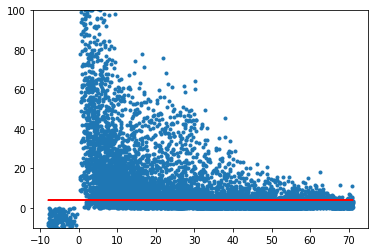

In [36]:
plt.plot(data_test[out],data_test['ErrSDpc'],'.')
plt.plot(data_test[out],4*np.ones(len(data_test[out])),'r')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
plt.ylim(-10,100)

In [37]:
ds=data_test['ErrSDpc'][data_test['ErrSDpc']<4]
fracOK=len(ds)/len(data_test)
fracOK

0.6356147021546261

In [38]:
# Get mean as standard deviation
mean = data_test[out+'_residuals'].mean()
std = data_test[out+'_residuals'].std()
std

2.6873767900479573

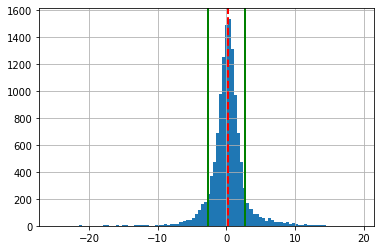

In [39]:
data_test[out+'_residuals'].hist(bins=100)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(std, color='g', linewidth=2)
plt.axvline(-std, color='g', linewidth=2)

<AxesSubplot:>

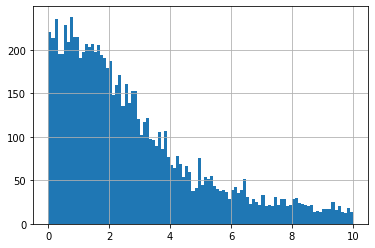

In [40]:
data_test['ErrSDpc'].hist(bins=100,range=[0,10])

In [63]:
data_test

,surge_distance_from_eq,surge_distance_from_eq_pred,surge_distance_from_eq_residuals,ErrSDpc
6188,20.677098,10.987704,9.689394,46.860510
40868,42.117870,38.388226,3.729644,8.855254
36553,53.090574,51.705257,1.385317,2.609346
57857,32.876043,16.573053,16.302989,49.589269
54851,58.150537,57.706963,0.443574,0.762804
...,...,...,...,...
27915,46.034399,46.142410,-0.108011,0.234632
37471,39.584269,39.365135,0.219134,0.553588
59217,60.302921,58.888737,1.414185,2.345135
42042,32.177321,31.832850,0.344471,1.070541


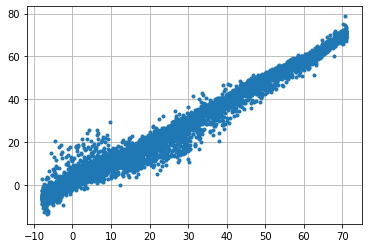

In [42]:
#out='surge_distance_from_eq'
plt.plot(data_test[out],data_test[out+'_pred'],'.')
plt.grid(True)

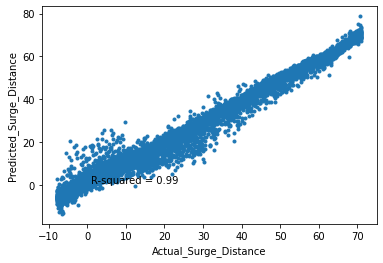

In [57]:
#fig, ax = plt.subplots()
plt.plot(data_test[out],data_test[out+'_pred'],'.')
#plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual_Surge_Distance')
plt.ylabel('Predicted_Surge_Distance')
#regression line
#r2_score = r2_score(data_test[out],data_test[out+'_pred'])
plt.text(0.9,0.8 , 'R-squared = %0.2f' % r2_score)
#plt.plot(data_test[out],data_test[out+'_pred'],'.')

plt.show()

In [ ]:
def plot_regression_results(ax,y_true,y_pred,title,scores):
    
    ax.plot([y_true.min(),y_true.max()],
           [y_true.min(),y_true.max()],'--r',linewidth=2)
    ax.scatter(y_true,y_pred,alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_xaxis().tick_left()
    ax.spines['left'].set_position(('outward',10))
    ax.spines['bottom'].set_position(('outward',10))
    ax.set_xlim([y_true.min(),y_true.max()])
    ax.set_ylim([y_true.min(),y_true.max()])
    ax.set_xlabel('Actual_Value_Surge_Distance')
    ax.set_ylabel('Predicted_Value_Surge_Distance')
    extra = plt.Rectangle((0,0),0,0,fc='w',fill = False,
                         edgecolor = 'none',linewidth=0)
    ax.legend([extra],[scores],loc = 'upper left')
    title = title 
    ax.set_title(title)
    
    
fig,ax = plt.plot(figsize=(9,7))
ax = np.ravel(ax)
R²_score = df_metrics['R²']
plot_regression_results(ax,data_test[out],data_test[out+'_pred'],'NN_Model',(r'$R²_score={:.3f}$' + '\n' + 
                                                    r'$
                                                                            
                                                                            ))
                 
    
    
    

# Check noise single point

In [65]:
INPUT_C=inputs
data[INPUT_C]
# A = multioutputregressor_1.predict(data[INPUT_C])
# for i, out in enumerate(OUTPUT_C):
#     data[out+'_pred'] = A[:,i]

DP=1486.939-1111.629
Pow=90.00619  

MyData=data[INPUT_C]
data1=MyData.loc[189:191,:]

data1

data1.loc[189:191,'Tin [K]']=314.6786
data1.loc[189:191,'Pin [kPa]']=1111.629
data1.loc[189:191,'N [rpm]']=2320.842
data1.loc[189,'Total Consumed power']=Pow*0.95
data1.loc[190,'Total Consumed power']=Pow
data1.loc[191,'Total Consumed power']=Pow*1.05
data1.loc[189:191,'Differential Pressure [kPa]']=DP

data1

# data2y = data1['Tin [K]'].copy()
X1_train_scaled, X1_test_scaled = scale_datasets(data1, data1)

A = model_loaded.predict(X1_train_scaled)

A#=pd.DataFrame(A)

array([[-318.13635 ],
       [  36.997208],
       [  83.92659 ]], dtype=float32)

In [66]:
Qin_GT = 136.0255 #Surge Distance, not Qin here 
Error = (Qin_GT-A[1])/Qin_GT 
Error_m5 = (Qin_GT-A[0])/Qin_GT
Error_p5 = (Qin_GT-A[2])/Qin_GT
Error_mp5 = (A[2]-A[0])/Qin_GT

# print('Error={:2.2%} ,Error_m5={:2.2%} ,Error_p5={:2.2%} ,Error_mp5= {:2.2%}'.format(Error,Error_m5,Error_p5,Error_mp5))
# --> TypeError: unsupported format string passed to numpy.ndarray.__format__ ???

print(Error,Error_m5,Error_p5,Error_mp5)

Inc_Error_m5=(Error_m5-Error)
Inc_Error_p5=(Error_p5-Error)
Inc_Error_mp5=(Error_mp5-Error)

# print('Inc_Error_m5={:2.2%} ,Inc_Error_p5={:2.2%} ,Inc_Error_mp5= {:2.2%}'.format(Inc_Error_m5,Inc_Error_p5,Inc_Error_mp5))
print(Inc_Error_m5,Inc_Error_p5,Inc_Error_mp5)

[0.7280127] [3.3387995] [0.3830084] [2.955791]
[2.610787] [-0.3450043] [2.2277784]
